In [1]:
import sys
import os

# Add the project root directory to the sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import torch
import yaml
from models.contrastive_vae import ContrastiveVAE
from data.data_loader import load_data_from_h5, get_data_loaders


# Load the configuration file
config_path = 'D:/Ziwei/Github/LVAE/config/config.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)



In [3]:
device = config['device']
experiment_dir = config['experiment_dir']
data_path = config['data']['path']
loader_params = config['loader']
model_params = config['model']['kwargs']
optimizer_params = config['optimizer']['kwargs']
criterion_params = config['criterion']
training_params = config['training']

In [4]:
data_path = config['data']['path']
train_point_clouds, test_point_clouds, train_labels, test_labels = load_data_from_h5(data_path)
batch_size = config['loader']['batch_size']


In [5]:
from data.augmentation import random_transform


train_loader, val_loader = get_data_loaders(train_point_clouds, train_labels, test_point_clouds, test_labels, batch_size, augmentations=random_transform)

# Get a batch of data
data_iter = iter(train_loader)
(original_pc, augmented_pc1, augmented_pc2), labels = next(data_iter)


In [6]:
original_pc = original_pc.numpy()
augmented_pc1 = augmented_pc1.numpy()
augmented_pc2 = augmented_pc2.numpy()

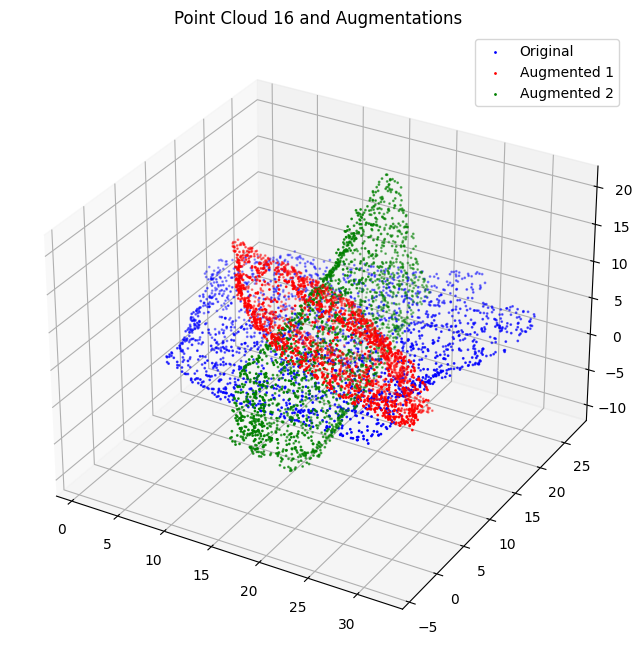

In [8]:
import matplotlib.pyplot as plt  # Correct import
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_clouds_together(original, augmented1, augmented2, idx):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot original point cloud in blue
    ax.scatter(original[2, :], original[1, :], original[0, :], s=1, color='b', label='Original')

    # Plot augmented point cloud 1 in red
    ax.scatter(augmented1[2, :], augmented1[1, :], augmented1[0, :], s=1, color='r', label='Augmented 1')

    # Plot augmented point cloud 2 in green
    ax.scatter(augmented2[2, :], augmented2[1, :], augmented2[0, :], s=1, color='g', label='Augmented 2')

    ax.set_title(f"Point Cloud {idx} and Augmentations")
    ax.legend()
    plt.show()


# Choose an index to visualize
i = 16

# Visualize the point clouds
visualize_point_clouds_together(original_pc[i], augmented_pc1[i], augmented_pc2[i], i)

In [5]:
input_dim = 1024 * 3  # Assuming 1024 points with 3 coordinates each
latent_dim = config['model']['kwargs']['latent_dim']
projection_dim = config['model']['kwargs']['projection_dim']
k = config['model']['kwargs']['k']
emb_dims = config['model']['kwargs']['emb_dims']

model = ContrastiveVAE(input_dim=input_dim, latent_dim=latent_dim, projection_dim=projection_dim, k=k, emb_dims=emb_dims)
model = model.to(torch.device(config['device']))

In [6]:
from pytorch_metric_learning import losses
# Initialize optimizer
optimizer_class = getattr(torch.optim, config['optimizer']['name'])
optimizer = optimizer_class(model.parameters(), **config['optimizer']['kwargs'])

# Initialize criterion
criterion = losses.NTXentLoss(temperature=config['criterion']['temperature'])
# Test a forward pass
data_iter = iter(train_loader)
data = next(data_iter)
augmented_batch, labels = data['points'], data['label']
augmented_batch = torch.tensor(augmented_batch, dtype=torch.float32).to(torch.device(config['device']))
# Ensure augmented_batch and labels are tensors
augmented_batch = augmented_batch.clone().detach().to(torch.device(config['device']))
labels = labels.clone().detach().to(torch.device(config['device']))

C:\Users\ljd567\AppData\Local\Temp\ipykernel_10868\2170236123.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  augmented_batch = torch.tensor(augmented_batch, dtype=torch.float32).to(torch.device(config['device']))


In [4]:
from training.train import ShapeTrainer
import yaml


# Initialize and run the trainer
trainer = ShapeTrainer(config)
trainer.run()


Epochs:   0%|          | 0/100 [02:15<?, ?it/s]


KeyboardInterrupt: 